# Island melting build file creation <img align="right" width="192" height="64" src="https://freemelt.com/app/uploads/freemeltLogo-1.png">

Electron Beam Melting is usually done using line melting patterns. A problem that arises with line melting is powder transport, when the electron beam pushes the powder ahead of itself. This causes internal stress, component warping and uneven surfaces, all obviously unwanted consequences. This issue is correlated with the line length, so larger components are more susceptible to powder transport. One way to mitigate this is to implement what is called an *island melting* strategy, where the build area is partitioned into a grid of overlapping rectangles, called *islands*. These islands are then subsequently melted one at a time in a certain order, varieties of which will be implemented in this guide. 





First of all, importing the necessary libraries:

In [13]:
import obplib as obp

#utility packages
import os 
import numpy as np
import notebook_viewer as nw
import random as rnd

#used solely for this guide
import jdc

The partitioning of the build area is done using overlapping rectangles, like the following picture:

|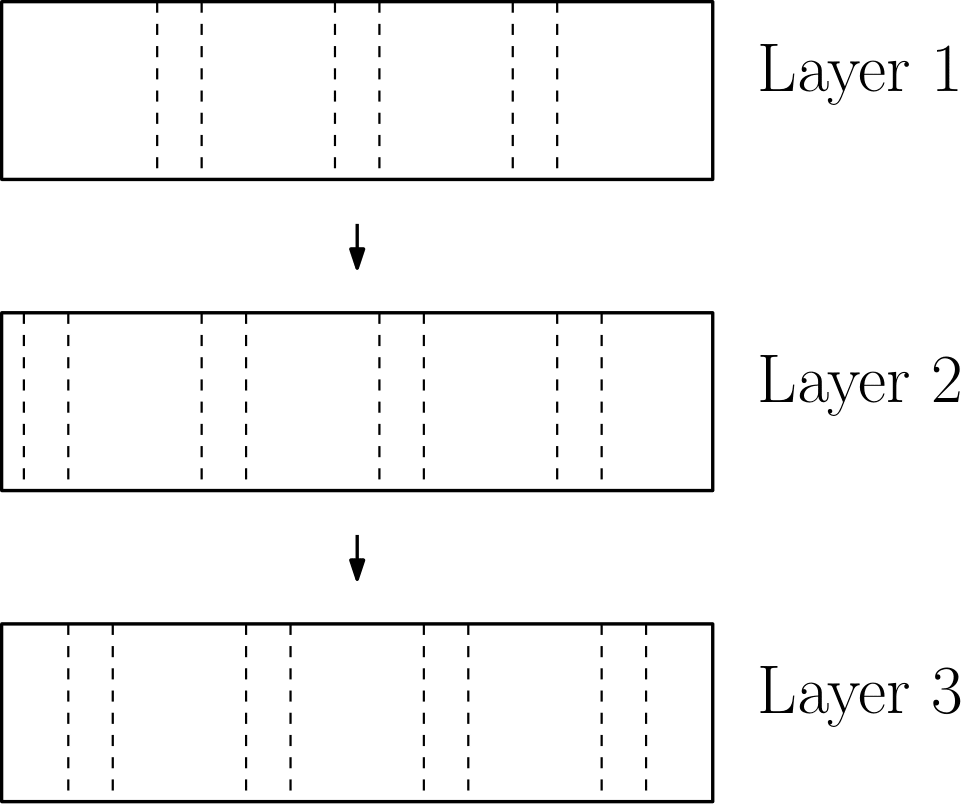|
|:--:|
|[Example of island melting]|

## Classes and points
To create these rectangles, the superclass `Shape` is first created, along with the child class `Rectangle` and a private boolean function that checks whether a point is inside the rectangle. Of course, other shapes such as circles and triangles could be supported, but as a rectangle is very simple to model mathematically, it will be the shape of choice for this guide. 

In [14]:
#superclass, stores midpoint as cartesian coordinates [x, y]
class Shape: 
    def __init__(self, midpoint):
        self.midpoint = midpoint

#child class of Shape, stores midpoint as cartesian coordinates and dimensions as measurements in x and y directions
class Rectangle(Shape):
    def __init__(self, midpoint, dimensions):
        super().__init__(midpoint)
        self.dimensions = dimensions

    #help function to determine whether a point is in a given rectangle defined by its midpoint and dimensions
    def _is_in_rectangle(self, point, midpoint, dimensions):
        x_min = midpoint[0] - dimensions[0] / 2
        x_max = midpoint[0] + dimensions[0] / 2
        y_min = midpoint[1] - dimensions[1] / 2
        y_max = midpoint[1] + dimensions[1] / 2

        return x_min <= point[0] <= x_max and y_min <= point[1] <= y_max

An example:

In [15]:
#test for Rectangle class, with two points where one is outside the rectangle and one is inside
midpoint = [0, 0]
dimensions = [1, 1]
test = Rectangle(midpoint, dimensions) #a square of height and width of 1, centered in the origin
point_1 = [2, 2]
point_2 = [0, 0]
print("Point 1 in rectangle: ", test._is_in_rectangle(point_1, midpoint, dimensions))
print("Point 2 in rectangle: ", test._is_in_rectangle(point_2, midpoint, dimensions))

Point 1 in rectangle:  False
Point 2 in rectangle:  True


Next the child class `Island` is introduced: 

In [16]:
#subclass of Rectangle
class Island(Rectangle):
    def __init__(self, build_dimensions, build_midpoint, midpoint, dimensions, margins, speed, spot_size, power):
        #island attributes
        super().__init__(midpoint, np.add(dimensions, np.multiply(margins, 2)))
        self.speed = speed #beam speed
        self.spot_size = spot_size #beam spot size
        self.power = power #beam power
        self.margins = margins #margin size as list of length 2 in x and y direction
        #build attributes
        self.build_dimensions = build_dimensions
        self.build_midpoint = build_midpoint

The `Island` class stores attributes that are related to the specific island, but also the build area attributes in order to be able to place points within the build object area.

Next, the points are placed in a square grid with a certain density, if the point is inside the build object:

In [17]:
%%add_to Island
#places points in a square grid with density as an argument
def _place_points(self, density):
    number_of_points = [int(self.dimensions[0] * density), int(self.dimensions[1] * density)]
    points = [
                [
                obp.Point(j / density + self.midpoint[0] - self.dimensions[0] / 2, i / density + self.midpoint[1] - self.dimensions[1] / 2) 
                for j in range(number_of_points[0] + 1)
                        if self._is_in_rectangle([j / density + self.midpoint[0] - self.dimensions[0] / 2, i / density + self.midpoint[1] - self.dimensions[1] / 2], self.build_midpoint, self.build_dimensions)
                ]
                for i in range(number_of_points[1] + 1)
    ]
    return [ele for ele in points if ele] #return points within the build area

Next, an example. The `Island` `isl_test` has the same dimensions as `test` from the previous example, but a margin that doubles the side width. However, since the margins would fall outside the `test` build area, the points outside have been omitted. 

In [18]:
isl_test = Island(build_dimensions = test.dimensions, build_midpoint = test.midpoint, midpoint = [0, 0], dimensions = [1, 1], margins = [1, 1], speed = 100, spot_size = 100, power = 100)
points = isl_test._place_points(density = 1) #place points with a density of 1 point per micrometer
point_information = [ #get the x and y coordinates of points
    [
        points[i][j].x, points[i][j].y
    ] 
    for i in range(len(points)) for j in range(len(points[i]))
    ] 
print(point_information)

[[-0.5, -0.5], [0.5, -0.5], [-0.5, 0.5], [0.5, 0.5]]


## Line melting pattern
A line melting pattern can be added, in this case the test pattern `place_lines_one_direction`. All it does is place a `Line` object starting at the leftmost point and ending at the rightmost point for every row in an `Island`. Afterwards, it saves the lines in an `.obp` file.

In [19]:
%%add_to Island
#test pattern, unidirectional beam paths from side to side
def place_lines_one_direction(self, density, filename):
    # Generate the points on the powder bed
    points = self._place_points(density)

    # Create the lines based on the points
    lines = []
    y_range = range(len(points))
    bp = obp.Beamparameters(self.spot_size, self.power)
    for y in y_range:
        lines.append(obp.Line(points[y][0], points[y][-1], self.speed, bp))

    # Write the lines to the file
    try:
        old_obp = obp.read_obp(filename)
        new_obp = old_obp + lines
        obp.write_obp(new_obp, filename)
    except:
        obp.write_obp(lines, filename)
    
    return lines

`isl_test` has two rows and two columns of points when `density = 1`, which would result in two lines. Reusing the previous examples to demonstrate:

In [20]:
lines = isl_test.place_lines_one_direction(density = 1, filename = "lines.txt")
nw.notebook_viewer(lines)

interactive(children=(IntSlider(value=1, description='upper_lim', max=2, min=1), IntText(value=2, description=…

Now to place the islands on the build object area. For this, the `Build_Area` object is introduced. It has a private method, `_populate_with_islands`, that calculates the size of the islands and initiates `Island` objects in an overlapping grid.

In [21]:
#'User interface' class
class Build_Area:
    def __init__(self, island_numbers, midpoint, build_dimensions, margins):
        self.midpoint = midpoint
        self.build_dimensions = build_dimensions
        self.margins = margins
        for i in range(2): #margins can't be larger than the island sizes
            if self.margins[i] >= self.build_dimensions[i] / island_numbers[i]:
                raise Exception("Margin too large!")
        self.islands = self._populate_with_islands(island_numbers)
            
    #populates the build object with partially overlapping islands
    def _populate_with_islands(self, island_numbers):
        islands = []
        island_dimensions = [ #compute the dimensions of the islands
            self.build_dimensions[0] / island_numbers[0],
            self.build_dimensions[1] / island_numbers[1],
        ]
        #compute the midpoint of the islands and populates the grid with islands
        for i in range(island_numbers[1]):
            for j in range(island_numbers[0]):
                island_midpoint = [
                    self.midpoint[0] + island_dimensions[0] * (j + 1 / 2)
                    - self.build_dimensions[0] / 2,
                   self.midpoint[1] +  island_dimensions[1] * (i  + 1 / 2)
                    - self.build_dimensions[1] / 2
                ]
                islands.append(Island(self.build_dimensions, self.midpoint, island_midpoint, island_dimensions, self.margins, speed = 100, spot_size = 100, power = 100))
        return [ele for ele in islands if ele]

Next, the islands are melted in order:

In [22]:
%%add_to Build_Area
#calls the melt pattern on each island
def melt_islands(self, density, filename):
    lines = []
    for island in self.islands:
        lines.extend(island.place_lines_one_direction(density, filename)) #change for different melting pattern
    return lines

### Example - 2 $\times$ 2 islands

In this example, a build area is divided into 2 $\times$ 2 islands and melted.

In [23]:
filename = "2_by_2_islands.obp"
try:    
    os.remove(filename)
except:
    pass

rec = Build_Area(island_numbers=[2, 2], midpoint=[0, 0], build_dimensions=[100, 100], margins=[5, 5])
lines = rec.melt_islands(density = 0.1, filename = filename)

#to view the lines
nw.notebook_viewer(lines)

interactive(children=(IntSlider(value=12, description='upper_lim', max=24, min=1), IntText(value=24, descripti…

## Changing island melting order
Adding to powder transport complexity, simply translating the islands isn't always sufficient. When the island melting order is repeated in consecutive layers, the melting process may become so similar over time that it leads to undesired stress and warping. A solution to this issue is to avoid repeating the island melting order for each layer and instead melt the islands in a random order every time. Additionally, the line reversal technique used in the [honeycomb notebook](https://mybinder.org/v2/gh/olofficial/hex-test/main?labpath=honeycomb.ipynb) can be applied here as well.

To summarize, the islands will be melted in a random order, and the line direction (right to left or left to right) will also be randomly chosen.

In [24]:
%%add_to Build_Area
#calls the melt pattern on each island in a random order
def melt_islands(self, density, filename):
    lines = []
    rnd.shuffle(self.islands)
    a = 1
    for island in self.islands:
        reverse_island = rnd.choice([True, False])
        lines = lines + island.place_lines_one_direction(density, filename, reverse_island) #change for different melting pattern
    return lines

In [25]:
%%add_to Island
#test pattern, unidirectional beam paths from side to side
def place_lines_one_direction(self, density, filename, reverse_island):
    # Generate the points on the powder bed
    points = self._place_points(density)

    # Create the lines based on the points
    lines = []
    y_range = range(len(points))
    bp = obp.Beamparameters(self.spot_size, self.power)
    for y in y_range:
        lines.append(obp.Line(points[y][0], points[y][-1], self.speed, bp))

    # Write the lines to the file
    try:
        old_obp = obp.read_obp(filename)
        new_obp = old_obp + lines
        obp.write_obp(new_obp, filename)
    except:
        obp.write_obp(lines, filename)
        
    if reverse_island == True:
        lines = [obp.Line(line.P2, line.P1, line.Speed, line.bp) for line in reversed(lines)]

    return lines

An example:

In [28]:
filename = "2_by_2_islands_reversed.obp"
try:    
    os.remove(filename)
except:
    pass

rec = Build_Area(island_numbers=[2, 2], midpoint=[0, 0], build_dimensions=[100, 100], margins=[5, 5])
lines = rec.melt_islands(0.1, filename)
nw.notebook_viewer(lines)

interactive(children=(IntSlider(value=12, description='upper_lim', max=24, min=1), IntText(value=24, descripti…

## Full code
With all this done, the island melting strategy is now implemented using `obplib`. The full code:

In [27]:
import obplib as obp
import os 
import numpy as np
import notebook_viewer as nw
import random as rnd

#superclass, stores midpoint as cartesian coordinates [x, y]
class Shape: 
    def __init__(self, midpoint):
        self.midpoint = midpoint

#child class of Shape, stores midpoint as cartesian coordinates and dimensions as measurements in x and y directions
class Rectangle(Shape):
    def __init__(self, midpoint, dimensions):
        super().__init__(midpoint)
        self.dimensions = dimensions

    #help function to determine whether a point is in a given rectangle defined by its midpoint and dimensions
    def _is_in_rectangle(self, point, midpoint, dimensions):
        x_min = midpoint[0] - dimensions[0] / 2
        x_max = midpoint[0] + dimensions[0] / 2
        y_min = midpoint[1] - dimensions[1] / 2
        y_max = midpoint[1] + dimensions[1] / 2

        return x_min <= point[0] <= x_max and y_min <= point[1] <= y_max
    
#subclass of Rectangle
class Island(Rectangle):
    def __init__(self, build_dimensions, build_midpoint, midpoint, dimensions, margins, speed, spot_size, power):
        #island attributes
        super().__init__(midpoint, np.add(dimensions, np.multiply(margins, 2)))
        self.speed = speed #beam speed
        self.spot_size = spot_size #beam spot size
        self.power = power #beam power
        self.margins = margins #margin size as list of length 2 in x and y direction
        #build attributes
        self.build_dimensions = build_dimensions
        self.build_midpoint = build_midpoint
    
    #places points in a square grid with density as an argument
    def _place_points(self, density):
        number_of_points = [int(self.dimensions[0] * density), int(self.dimensions[1] * density)]
        points = [
                    [
                    obp.Point(j / density + self.midpoint[0] - self.dimensions[0] / 2, i / density + self.midpoint[1] - self.dimensions[1] / 2) 
                    for j in range(number_of_points[0] + 1)
                            if self._is_in_rectangle([j / density + self.midpoint[0] - self.dimensions[0] / 2, i / density + self.midpoint[1] - self.dimensions[1] / 2], self.build_midpoint, self.build_dimensions)
                    ]
                    for i in range(number_of_points[1] + 1)
        ]
        return [ele for ele in points if ele] #return points within the build area
    
    #test pattern, unidirectional beam paths from side to side
    def place_lines_one_direction(self, density, filename, reverse_island):
        # Generate the points on the powder bed
        points = self._place_points(density)

        # Create the lines based on the points
        lines = []
        y_range = range(len(points))
        bp = obp.Beamparameters(self.spot_size, self.power)
        for y in y_range:
            lines.append(obp.Line(points[y][0], points[y][-1], self.speed, bp))

        if reverse_island == True:
            lines = [obp.Line(line.P2, line.P1, line.Speed, line.bp) for line in reversed(lines)]
        
        # Write the lines to the file
        try:
            old_obp = obp.read_obp(filename)
            new_obp = old_obp + lines
            obp.write_obp(new_obp, filename)
        except:
            obp.write_obp(lines, filename)
        return lines
    
#'User interface' class
class Build_Area:
    def __init__(self, island_numbers, midpoint, build_dimensions, margins):
        self.midpoint = midpoint
        self.build_dimensions = build_dimensions
        self.margins = margins
        for i in range(2): #margins can't be larger than the island sizes
            if self.margins[i] >= self.build_dimensions[i] / island_numbers[i]:
                raise Exception("Margin too large!")
        self.islands = self._populate_with_islands(island_numbers)
            
    #populates the build object with partially overlapping islands
    def _populate_with_islands(self, island_numbers):
        islands = []
        island_dimensions = [ #compute the dimensions of the islands
            self.build_dimensions[0] / island_numbers[0],
            self.build_dimensions[1] / island_numbers[1],
        ]
        #compute the midpoint of the islands and populates the grid with islands
        for i in range(island_numbers[1]):
            for j in range(island_numbers[0]):
                island_midpoint = [
                    self.midpoint[0] + island_dimensions[0] * (j + 1 / 2) - self.build_dimensions[0] / 2,
                    self.midpoint[1] +  island_dimensions[1] * (i  + 1 / 2) - self.build_dimensions[1] / 2
                ]
                islands.append(Island(self.build_dimensions, self.midpoint, island_midpoint, island_dimensions, self.margins, speed = 100, spot_size = 100, power = 100))
        return [ele for ele in islands if ele]
    
    #calls the melt pattern on each island in a random order
    def melt_islands(self, density, filename):
        try:    
            os.remove(filename)
        except:
            pass
        lines = []
        rnd.shuffle(self.islands)
        for island in self.islands:
            reverse_island = rnd.choice([True, False])
            lines = lines + island.place_lines_one_direction(density, filename, reverse_island) #change for different melting pattern
        return lines

#code example 
filename = "island.obp"

rec = Build_Area(island_numbers=[10, 10], midpoint=[0, 0], build_dimensions=[100, 100], margins=[5, 5])
lines = rec.melt_islands(0.05, filename)
nw.notebook_viewer(lines)

interactive(children=(IntSlider(value=90, description='upper_lim', max=180, min=1), IntText(value=180, descrip…